In [99]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
\
from sklearn.metrics import mean_squared_error

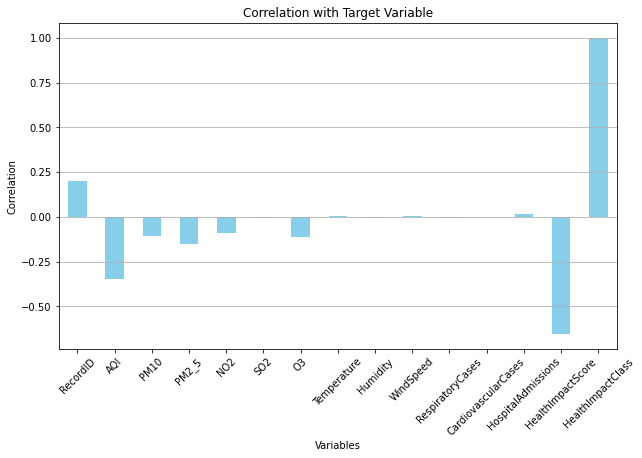

In [82]:
df_orig=pd.read_csv('air_quality_health_impact_data.csv')
correlations = df_orig.corrwith(df_orig['HealthImpactClass'])

# Plot correlations
correlations.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Correlation with Target Variable')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
df=df_orig.drop(columns=['HealthImpactClass','RecordID'])


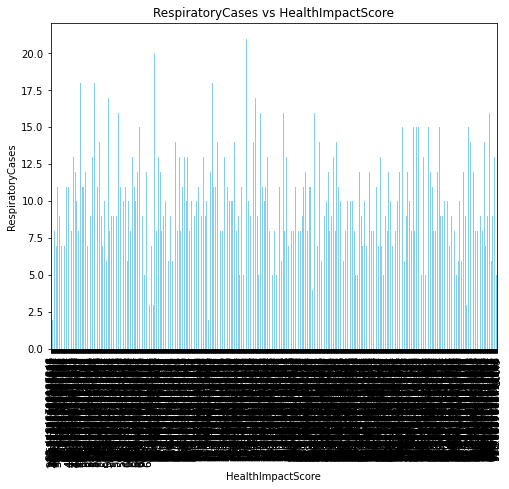

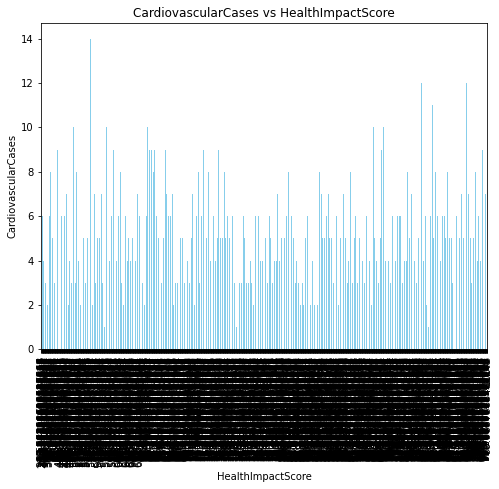

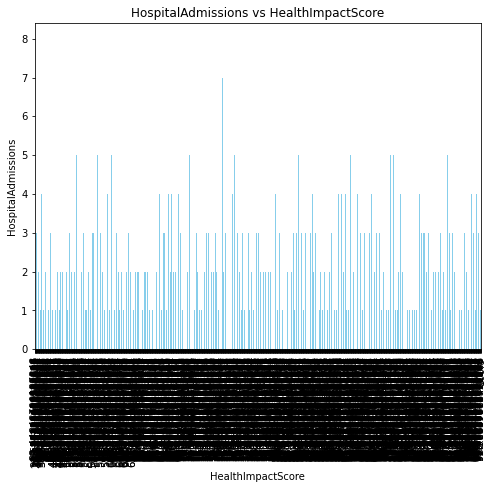

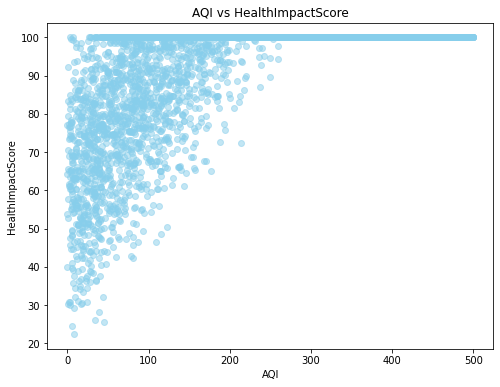

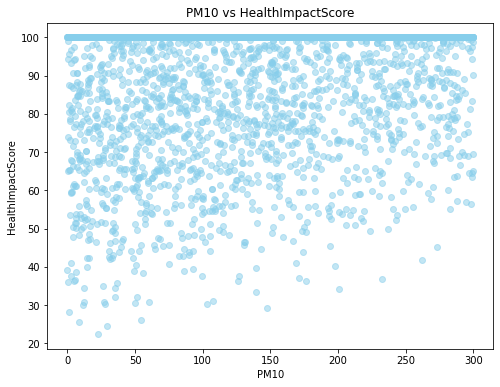

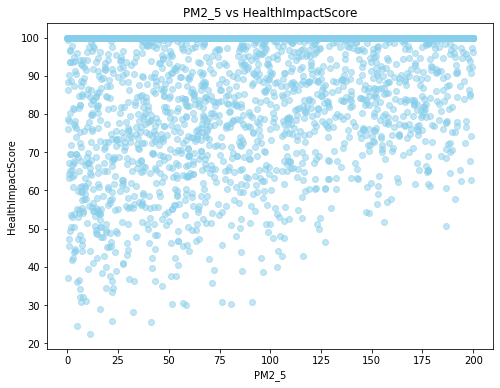

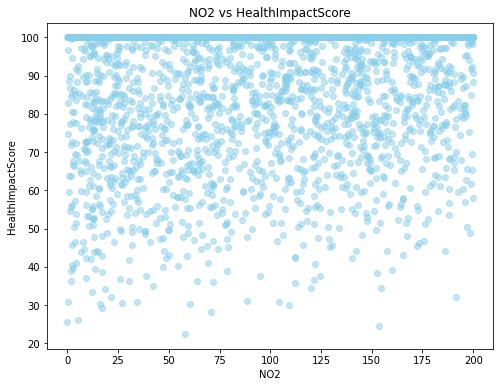

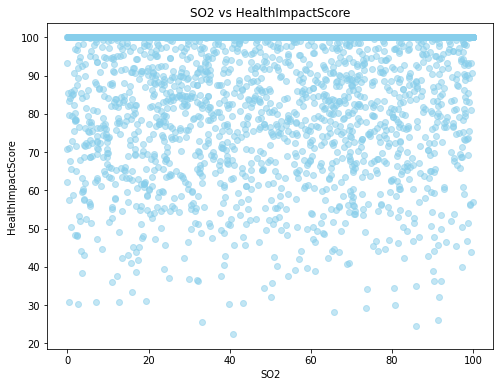

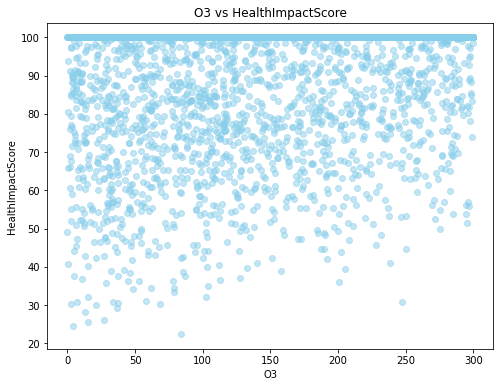

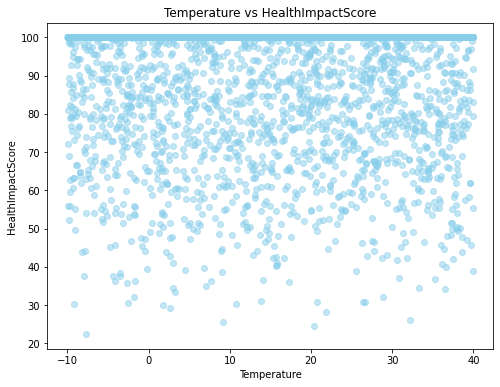

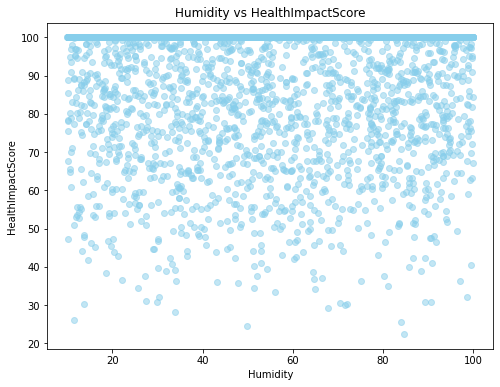

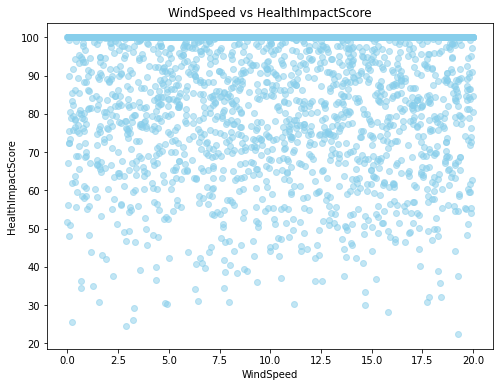

In [83]:
columns = df.columns

# Separate discrete and continuous variables
discrete_vars = ['RespiratoryCases','CardiovascularCases','HospitalAdmissions']
continuous_vars = ['AQI','PM10','PM2_5','NO2','SO2','O3','Temperature','Humidity','WindSpeed']
target_variable='HealthImpactScore'


# Plot discrete variables as bar plots
for col in discrete_vars:
    plt.figure(figsize=(8, 6))
    df.groupby(target_variable)[col].mean().plot(kind='bar', color='skyblue')
    plt.title(f'{col} vs {target_variable}')
    plt.xlabel(target_variable)
    plt.ylabel(col)
    plt.show()

# Plot continuous variables as scatter plots
for col in continuous_vars:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[col], df[target_variable], color='skyblue', alpha=0.5)
    plt.title(f'{col} vs {target_variable}')
    plt.xlabel(col)
    plt.ylabel(target_variable)
    plt.show()

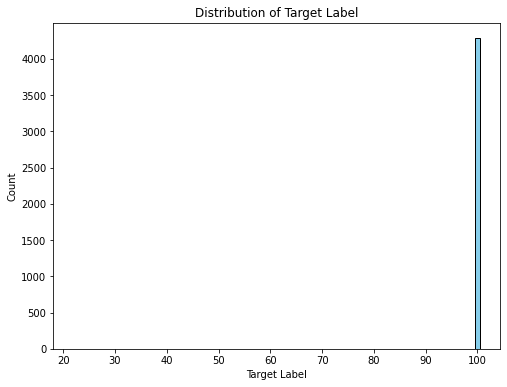

In [84]:
unique_values, counts = np.unique(df['HealthImpactScore'], return_counts=True)

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(unique_values, counts, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.title('Distribution of Target Label')

# Display the plot
plt.show()

In [111]:
num_bins = 10  # Choose the number of bins
df['target_bin'] = pd.cut(df['HealthImpactScore'], bins=num_bins, labels=False)


# Drop the bin column

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='HealthImpactScore'), df['HealthImpactScore'], test_size=0.2, random_state=42,stratify=df['target_bin'])
X_train.drop(columns=['target_bin'], inplace=True)
X_test.drop(columns=['target_bin'], inplace=True)
print(discrete_vars)
X_train_continuous = X_train[continuous_vars]
X_train_discrete = X_train[discrete_vars]
X_test_continuous = X_test[continuous_vars]
X_test_discrete = X_test[discrete_vars]
SC= StandardScaler()
X_train_continuous_sc=pd.DataFrame(SC.fit_transform(X_train_continuous),columns=continuous_vars,index=X_train.index)
X_test_continuous_sc=pd.DataFrame(SC.transform(X_test_continuous),columns=continuous_vars,index=X_test.index)
X_train_scaled = pd.concat([X_train_continuous_sc, X_train_discrete], axis=1,ignore_index=True)
X_test_scaled = pd.concat([X_test_continuous_sc, X_test_discrete], axis=1,ignore_index=True)
# encoder = OneHotEncoder(sparse=False)
# y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
# y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))
# smote = SMOTE()
# X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_scaled, y_train_encoded)
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train_oversampled, axis=1)),y= np.argmax(y_train_oversampled, axis=1))
# print(class_weights)
# class_weights = dict(enumerate(class_weights))

['RespiratoryCases', 'CardiovascularCases', 'HospitalAdmissions']


In [112]:
inputs = Input(shape=(X_train_scaled.shape[1],))

# Define hidden layers
hidden1 = Dense(64, activation='relu')(inputs)
hidden2 = Dense(64, activation='relu')(hidden1)
hidden3 = Dense(128, activation='relu')(hidden2)
hidden4 = Dense(128, activation='relu')(hidden3)

hidden5 = Dense(256, activation='relu')(hidden4)
hidden6 = Dense(256, activation='relu')(hidden5)
hidden7 = Dense(64, activation='relu')(hidden6)
hidden8 = Dense(64, activation='relu')(hidden7)

# Define output layer
outputs = Dense(1,activation='linear')(hidden8)  # Output layer with 1 neuron for regression or sigmoid activation for binary classification

# Create the model
model = Model(inputs=inputs, outputs=outputs)


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test)

predictions = model.predict(X_test_scaled)



Epoch 1/100
117/117 [==============================] - 2s 4ms/step - loss: 1669.5869 - val_loss: 310.0909
Epoch 2/100
117/117 [==============================] - 0s 3ms/step - loss: 279.0107 - val_loss: 213.5351
Epoch 3/100
117/117 [==============================] - 0s 3ms/step - loss: 185.4006 - val_loss: 164.9147
Epoch 4/100
117/117 [==============================] - 0s 3ms/step - loss: 141.2526 - val_loss: 123.0370
Epoch 5/100
117/117 [==============================] - 0s 3ms/step - loss: 112.0810 - val_loss: 94.3068
Epoch 6/100
117/117 [==============================] - 0s 3ms/step - loss: 77.3341 - val_loss: 57.8716
Epoch 7/100
117/117 [==============================] - 0s 3ms/step - loss: 40.0079 - val_loss: 29.8417
Epoch 8/100
117/117 [==============================] - 0s 3ms/step - loss: 23.0495 - val_loss: 26.0901
Epoch 9/100
117/117 [==============================] - 0s 3ms/step - loss: 20.0956 - val_loss: 16.6109
Epoch 10/100
117/117 [==============================] - 0s 3ms/

In [113]:
clipped_predictions = np.clip(predictions, 0, 100)
results = pd.DataFrame({'y_test': y_test, 'predictions': clipped_predictions.flatten()})
print(results)

mse = mean_squared_error(y_test, predictions)

print("Mean Squared Error:", mse)

          y_test  predictions
634    82.733139    85.359879
750    71.906830    71.801605
2713  100.000000    99.583351
3107   77.678272    77.410713
4572  100.000000    99.832275
...          ...          ...
176   100.000000    99.553276
4896   96.705197    96.128540
308   100.000000    99.826813
4351  100.000000    99.786888
905   100.000000    99.554329

[1163 rows x 2 columns]
Mean Squared Error: 0.2417994414967156
